# Correlations of the Zhao parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
import emcee
from multiprocessing import Pool

In [2]:
data = pd.read_csv(r'./../experiment26/zhao/profiles_fit/gamma=1.0/fit_dn_gamma=1.0_0.10_382_3.csv', 
                   delimiter='\s+')

bounds = pd.read_csv(r'./../bounds/gamma=1.0/r_bounds_gamma=1.0_0.10_3_0.csv', delimiter='\s+')
r_min = bounds.loc[382, 'r_min_smooth']
r_max = bounds.loc[382, 'r_max_smooth']

popts = pd.read_csv(r'./../experiment26/zhao/profiles_fit/gamma=1.0/fit_popts_gamma=1.0_0.10_3.csv', 
                    delimiter='\s+')

rho0  = popts.loc[0, 'ro0']
a     = popts.loc[0, 'a']
alpha = popts.loc[0, 'alpha']
beta  = popts.loc[0, 'beta']
gamma = popts.loc[0, 'gamma']


rho0_err  = popts.loc[0, 'ro0_err']
a_err     = popts.loc[0, 'a_err']
alpha_err = popts.loc[0, 'alpha_err']
beta_err  = popts.loc[0, 'beta_err']
gamma_err = popts.loc[0, 'gamma_err']

### functions

In [3]:
def f_zhao(r, rho0, a, alpha, beta, gamma):
    x = r / a
    f = 4 * np.pi * r**2 * rho0 / x ** gamma / ( 1 + x ** alpha ) ** ((beta - gamma) / alpha)
    return f

def log_likelihood(theta, x, dx, y, weight):
    rho0, a, alpha, beta, gamma = theta
    model     = f_zhao(x, rho0, a, alpha, beta, gamma) * dx       
    log_lh   = np.sum((model - y) ** 2 / model)
    
    if np.isnan(log_lh):
        return -np.inf
        
    if (log_lh > 0.531 * (len(x)-len(theta))):
        return -1e3 * log_lh
    
    return float(-log_lh * weight)

def log_prior(theta, mean_theta, std_theta, weight):
    lh_prior = 0
    bias = (theta - mean_theta) ** 2 / std_theta ** 2
    if (bias > 9.01).any():
        return -np.inf
    bias *= weight
    return - bias.sum()

def log_probability(theta, mean_theta, std_theta, x, dx, y, weight_pr=1e-5, weight_lh=1e-2):
    lp = log_prior(theta, mean_theta, std_theta, weight_pr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, dx, y, weight_lh)

In [4]:
mask = ((data['r'] + data['dr'] / 2) > r_min) & ((data['r'] - data['dr'] / 2) < r_max)
radius = data['r'][mask].to_numpy()
dn = data['dn'][mask].to_numpy()
dr = data['dr'][mask].to_numpy()

In [5]:
labels = [r"$\rho_0$", r"$a$",  r"$\alpha$", r"$\beta$", r"$\gamma$"]
labels += ["log prob", "log prior"]

 ### Initial conditions for walkers

In [6]:
np.random.seed(42)

Nwalkers = 10
Ndim     = 5       # number of parameters to define

mean_theta    = np.array([   rho0,    a,  alpha,  beta,   gamma ], dtype=np.float64)
#std_theta     = np.array([   rho0_err,    a_err,  alpha_err,  beta_err,   gamma_err  ])
std_theta     = np.array([  10.0,  0.5,    0.3,   0.5,    0.13  ])
weight_theta  = 1e-5
weight_lh = 1e-2


p0 = np.zeros((Nwalkers, Ndim), dtype=float)
for ip in range(Ndim):        
    for iw in range(Nwalkers):
        p0[iw][ip] = mean_theta[ip] + 6 * std_theta[ip] * (np.random.rand(1) - 0.5)

In [7]:
start = time.time()
lf = 0
for j in range(Nwalkers):
    add = log_probability(p0[j], mean_theta, std_theta, radius, dr, dn)
    lf += add
end = time.time()
lf /= Nwalkers

print((end - start)/Nwalkers)
print(lf)

9.038448333740235e-05
-57984061.57292502


In [8]:
# pool = Pool(processes=int(Nwalkers/3))
sampler = emcee.EnsembleSampler(Nwalkers, Ndim, log_probability, args=(mean_theta, std_theta, radius, dr, dn))

In [9]:
# Burn-in for walkers to go out
show_plot = 0
start = time.time()
state = sampler.run_mcmc(p0, 200)
sampler.reset()
end = time.time()
print(end - start)

0.09151530265808105


In [10]:
max_n = 300000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(state, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

 65%|██████▌   | 195800/300000 [41:38<22:09, 78.37it/s]   


[]

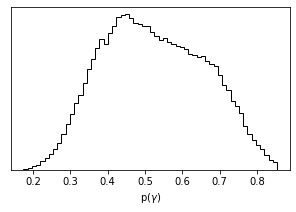

In [11]:
#  Show individual distributions
#  rho0,    a,     alpha,   beta,   gamma

j=4
samples = sampler.get_chain(flat=True)

fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(samples[:,j], 60, color="k", histtype="step")
ax.set_xlabel(labels[j])
ax.set_xlabel(r"p(" + labels[j] +r")")
ax.set_yticks([])

In [12]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.209


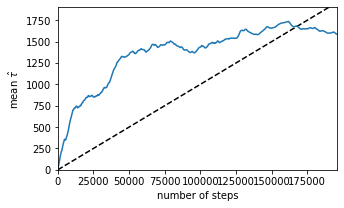

In [13]:
n = 100 * np.arange(1, index + 1)
y = autocorr[:index]

fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(n, n / 100.0, "--k")
ax.plot(n, y)
ax.set_xlim(0, n.max())
ax.set_ylim(0, y.max() + 0.1 * (y.max() - y.min()))
ax.set_xlabel("number of steps")
ax.set_ylabel(r"mean $\hat{\tau}$");

fname = "mean_t.png"
fig.savefig(fname, bbox_inches='tight')

burn-in: 3915
thin: 542
flat chain shape: (3540, 5)
flat log prob shape: (3540,)


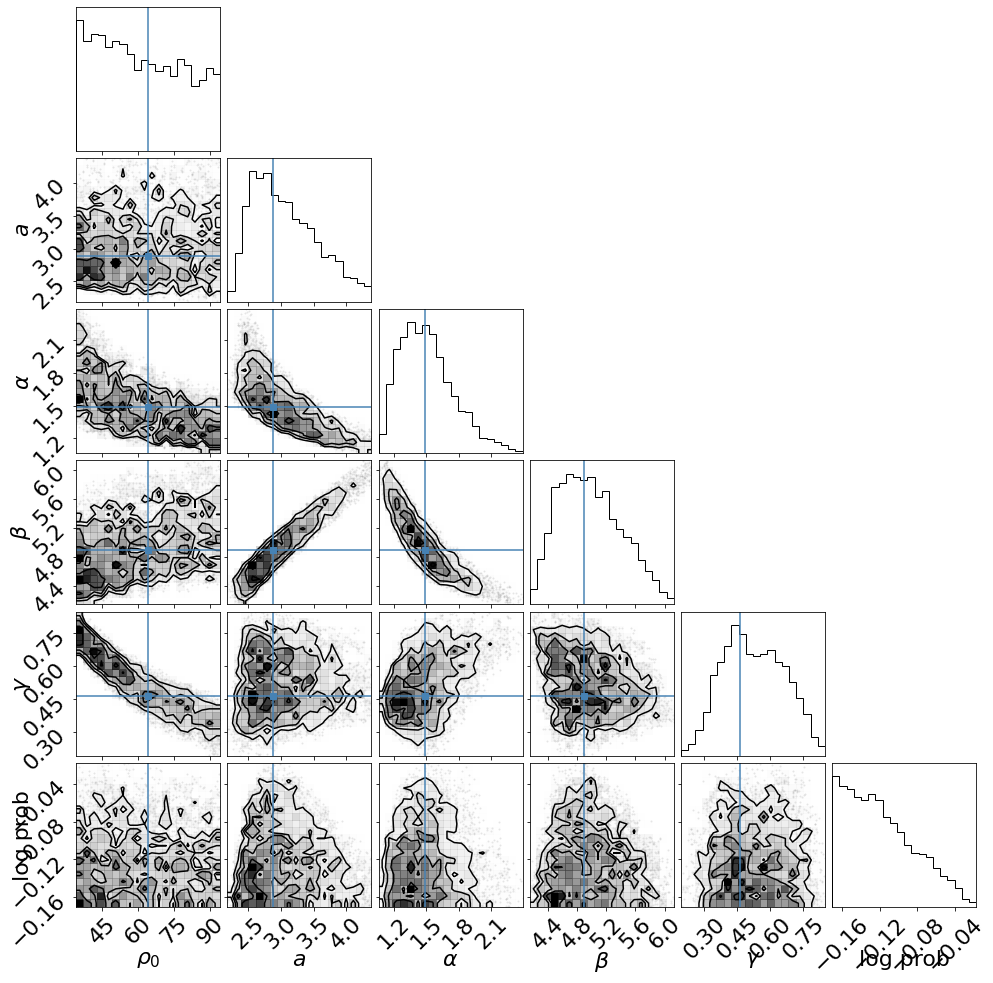

In [17]:
import corner

tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
# print("flat log prior shape: {0}".format(log_prior_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None]), axis=1
)

'''
all_samples = np.concatenate(
    (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
)
'''

# labels = list(map(r"$\theta_{{{0}}}$".format, range(1, Ndim + 1)))
plt.rcParams.update({'font.size': 22})

fig = corner.corner(all_samples, labels=labels, truths=np.append(mean_theta[:], np.array([0.0])) );
axes = np.array(fig.axes)
fname = "corner_jn.png"
fig.savefig(fname, bbox_inches='tight')

In [18]:
for i in range(Ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{0:7.3f}    -{1:6.3f}    {2:6.3f}"
    txt = txt.format(mcmc[1], q[0], q[1])
    display(txt)

' 59.503    -17.862    22.649'

'  2.985    - 0.419     0.621'

'  1.479    - 0.220     0.283'

'  4.941    - 0.409     0.507'

'  0.515    - 0.135     0.162'

In [19]:
from IPython.display import display, Math

for i in range(Ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>